## MGSC 695 - Optimization Methods for Data Science

## Winter 2024

## Dr. Sanjith Gopalakrishnan

### Submitted by - Jared Balakrishnan (McGill ID # 261175926)

In [106]:
from pathlib import Path 
import pandas as pd
import numpy as np
import gurobipy as gb 
from gurobipy import *

import matplotlib.pyplot as plt 
from matplotlib import style 
style.use('ggplot')
import seaborn as sns

In [89]:
dataset_path = Path().absolute() / "dataset"

In [90]:
# function to read in a dataset
def read_df(input_filepath: Path) -> pd.DataFrame:

    return pd.read_csv(input_filepath)

In [91]:
old_faithful = read_df(dataset_path / "faithful.csv")

In [92]:
del old_faithful['Unnamed: 0']

In [93]:
old_faithful.head(3)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74


In [95]:
# Number of instances and features

n = old_faithful.shape[0]
d = old_faithful.shape[1] 

print(f"Number of instances: {n}")
print(f"Number of features of interest: {d}")

Number of instances: 272
Number of features of interest: 2


## Problem 1

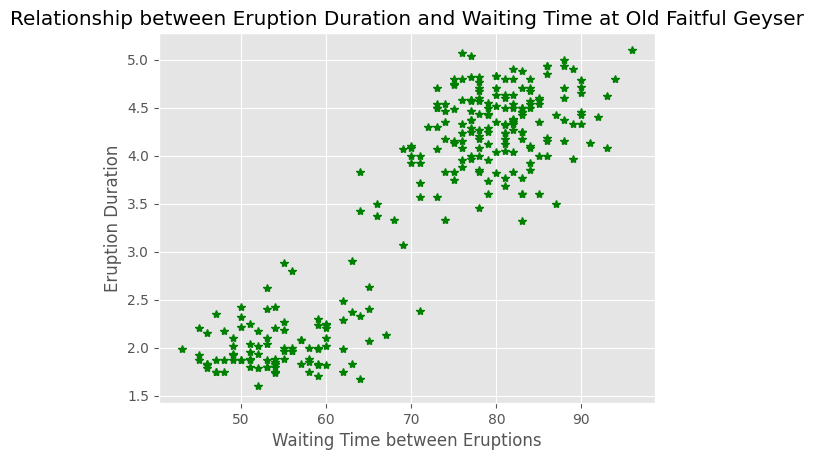

In [96]:
# Visualizing the observations using a scatter plot

plt.plot(old_faithful['waiting'], old_faithful['eruptions'], 'g*')
plt.title('Relationship between Eruption Duration and Waiting Time at Old Faitful Geyser')
plt.xlabel('Waiting Time between Eruptions')
plt.ylabel('Eruption Duration')
plt.show()

## The K-Means Clustering Problem

The K-Means Clustering algorithm is an unsupervised learning method that partitions a given dataset into K distinct, non-overlapping clusters.

In order to perform K-Means clustering algorithms, we need to decide upon the number of clusters (K). The K-Means algorithm then assigns each observation to exactly one of these K clusters.

Let $C_{1}, C_{2}, \cdots, C_{K}$ denote the sets that contain indices of the observations in each cluster:
- $C_{1} \cup C_{2} \cup \cdots \cup C_{K} = \{1, 2, \cdots, n\}$ (This means that each observation belongs to one of the K clusters)
- $ C_k \cap C_{{k'}} = \phi  \forall k \neq k'$ (An observation can only belong to one single cluster)

### The Optimization Problem

When it comes to expressing the K-Means clustering problem as an optimization problem, the principal idea is to minimize the **within-cluster** variation. The within-cluster variation for a given cluster is expressed as the amount by which observations within that particular cluster differ from each other.

Mathematically, the within-cluster variation can be expressed with the help of the Euclidean distance. That is, the within-cluster variation for a given cluster is defined as the sum of all pairwise euclidean distances between the observations in that given cluster divided by the number of observations in said cluster.

That is, with the within-cluster variation for a cluster $k$ being expressed as $W(C_{k})$ :

$$
W(C_k) = \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2
$$

Therefore, the optimization problem can now be summarized as:

$$
\text{minimize} \left\{ \sum_{k=1}^{K} \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^{p} (x_{ij} - x_{i'j})^2 \right\}
$$


In [97]:
# Implementing the K-Means Algorithm from Scratch for Clustering

old_faithful.head(2)

,eruptions,waiting
0,3.6,79
1,1.8,54


### Description of the custom k-Means Clustering Implementation

The custom implementation of the k-Means Clustering algorithm is implemented using the object oriented paradigm that python allows one to use.

The attributes of the k-Means classifier are as follows:
- k: The number of clusters to be created. Default is 2.
- tol: Tolerance, used in convergence considerations. In other words, if the change in the centroid values doesn't exceed this value, we can say that we have an optimized clustering. Default is 0.001. (scikit learn uses 0.0001 which seems too small)
- max_iter: Number of iterations to run the algorithm for. Default is 500.

In [98]:
# converting the input data into a NumPy array
faithful_array = old_faithful[['eruptions', 'waiting']].to_numpy()

In [102]:
colors = 10 * ["g", "r", "c", "b", "k"]

In [135]:
class customKMeans:

    def __init__(self, k = 2, tol = 0.001, max_iter = 500):

        self.k = k                  # number of clusters (k)
        self.tol = tol              # how much the centroid is going to move, shown in % change
        self.max_iter = max_iter    # how many times are we running this

    def fit(self, data):

        """
        Code to fit our data to - the empty dictionary named centroids will hold the values
        for the clusters' centroids. Then iteratively, we assign the starting centroids to be
        the first 2 or 3 data points in our dataset (depends on K).
        """

        # initializing an empty dictionary to store the centroids
        self.centroids: dict = {}

        for i in range(self.k):

            # storing the centroids - this will run depending on the value of k
            # since k refers to the number of clusters
            self.centroids[i] = data[i]
        
        for i in range(self.max_iter):

            # dictionary that contains centroids and the classifications
            self.classifications: dict = {}

            # the value for each classification begins with an empty list that will be appended
            for i in range(self.k):

                self.classifications[i] = []
            
            for featureset in data:

                # calculating a list of the euclidean distances for the points with respect to the centroids
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]

                classification = distances.index(min(distances))

                self.classifications[classification].append(featureset)

                # starting centroids don't change - for each iteration, we first clear out the classification since we'd move the centroids
                # and the classification is redone
            
            prev_centroids = dict(self.centroids)

            for classification in self.classifications:

                
                # redefining the centroids:
                self.centroids[classification] = np.average(self.classifications[classification], axis = 0)

            optimized = True 

            for c in self.centroids:

                # setting up the centroids for the subsequent iterations
                
                original_centroids = prev_centroids[c]

                current_centroids = self.centroids[c]

                if np.sum((current_centroids - original_centroids)/original_centroids*100.0) > self.tol:

                    optimized = False

            if optimized:

                break

    def predict(self, data):

        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]

        classification = distances.index(min(distances))

        return classification




## Clustering with K = 3

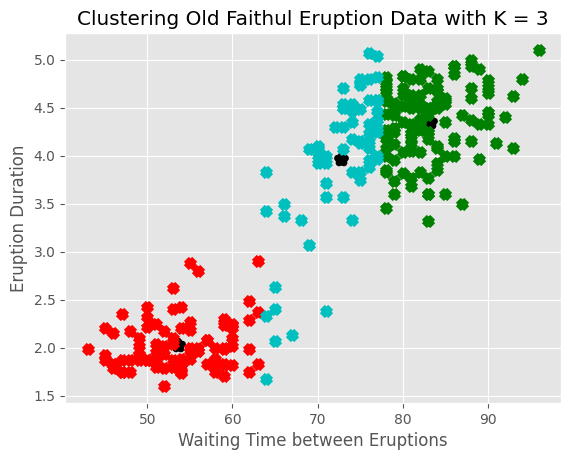

In [127]:
clf = customKMeans(k = 3)

clf.fit(faithful_array)

# plotting the results of clustering

# plotting the centroids

for centroid in clf.centroids:

    plt.scatter(clf.centroids[centroid][1], clf.centroids[centroid][0], marker = "*", color = "k", linewidths = 5)

# plotting the result of our clustering
for classification in clf.classifications:

    color = colors[classification]

    for featureset in clf.classifications[classification]:

        plt.scatter(featureset[1], featureset[0], marker = "x", color = color, linewidths = 5)

plt.xlabel('Waiting Time between Eruptions')
plt.ylabel('Eruption Duration')
plt.title('Clustering Old Faithul Eruption Data with K = 3')
plt.show()

## Clustering with K = 2

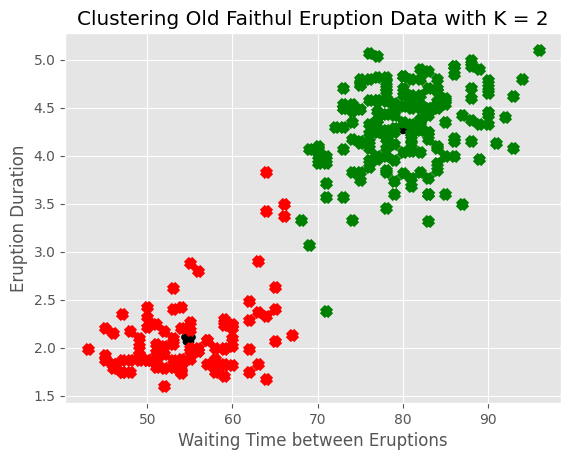

In [128]:
clf_2 = customKMeans(k = 2)

clf_2.fit(faithful_array)

# plotting the results of clustering

# plotting the centroids

for centroid in clf_2.centroids:

    plt.scatter(clf_2.centroids[centroid][1], clf_2.centroids[centroid][0], marker = "*", color = "k", linewidths = 5)

# plotting the result of our clustering
for classification in clf_2.classifications:

    color = colors[classification]

    for featureset in clf_2.classifications[classification]:

        plt.scatter(featureset[1], featureset[0], marker = "x", color = color, linewidths = 5)

plt.xlabel('Waiting Time between Eruptions')
plt.ylabel('Eruption Duration')
plt.title('Clustering Old Faithul Eruption Data with K = 2')
plt.show()

## Visual Interpretation

From a visual interpretation, I wanted to test for K values of 2 and 3. Both yield pretty good clustering for the custom k-Means implementation.

# Problem 2 - Image Compression

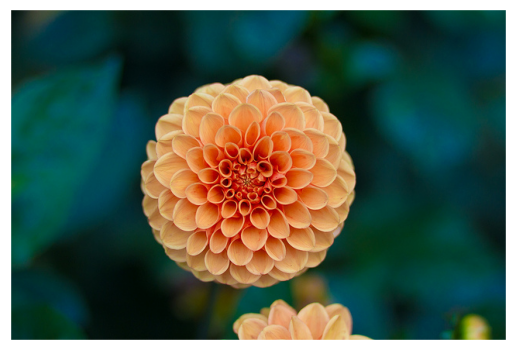

In [108]:
from sklearn.datasets import load_sample_image    # Datasets containing sample images in the scikit-learn library
flower = load_sample_image("flower.jpg")            # Loads a sample image flower.jpg
ax = plt.axes(xticks=[], yticks=[])               # Plot the image
ax.imshow(flower);

The image is stored in a three-dimensional array of height, width, RGB intensity. 

In [109]:
flower.shape

(427, 640, 3)

We will now reshape the image to transform it from a three-dimensional array to a two-dimensional array and store the RGB intensity to lie between 0 and 1 for convenience.

In [110]:
data = flower / 255.0                # Converts RGB intensity to a [0,1] scale
data = data.reshape(427 * 640, 3)   # Reshapes the image
data.shape

(273280, 3)

To understand the variety of pixel colors in the image, let us choose 10000 pixels and plot their colors. 

In [111]:
# Define a plot_pixels function 

def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # Choose a random subset of pixels 

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    # Define the axes and markets on the figure
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

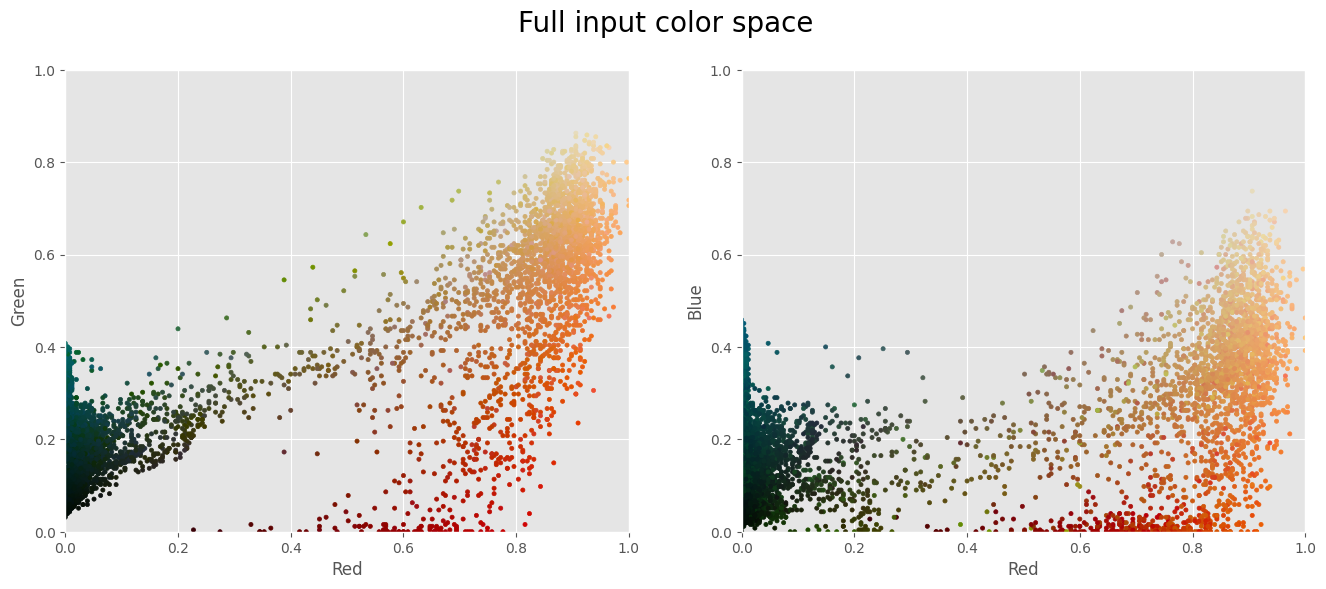

In [112]:
plot_pixels(data, title='Full input color space')


The entire input color space contains $256\cdot 256\cdot 256 = 16.77$ million colors.

## Compression using scikit-learn's Black-Box Mini-Batch k-Means 

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


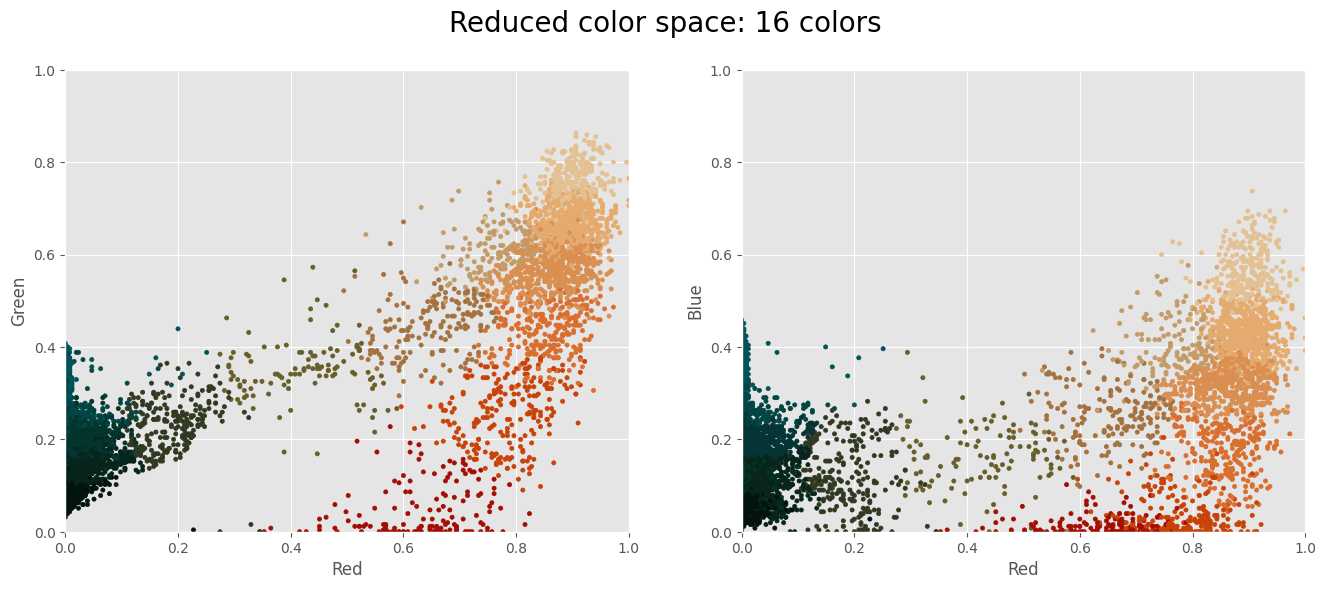

In [114]:
# Import and run the minibatchkmeans function from sklearn

from sklearn.cluster import MiniBatchKMeans

# Perform K-means with K = 16 

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# Plot the reduced color space using the 16 colors 

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

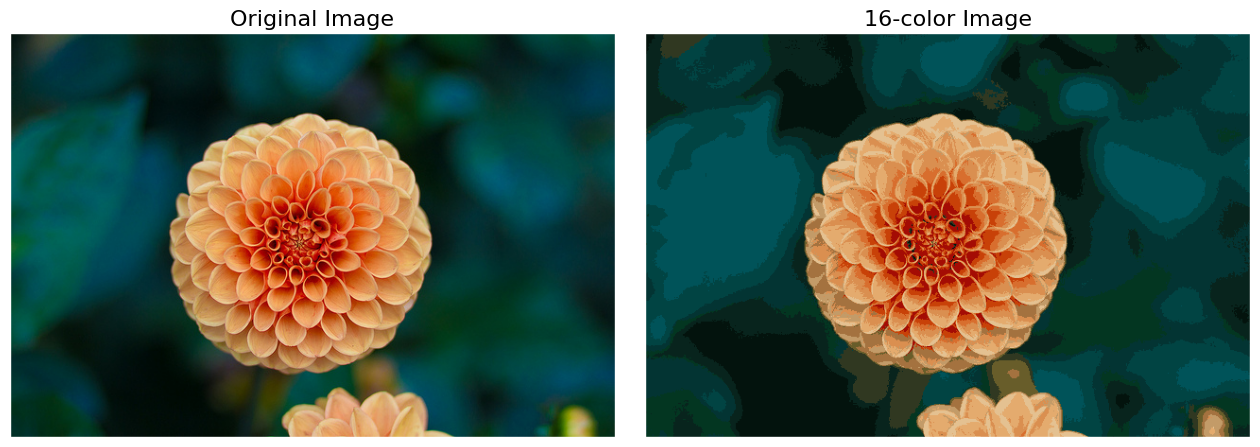

In [115]:
flower_recolored = new_colors.reshape(flower.shape) # Defines the recolored image

# Plots the original image and the recolored image for comparison

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16);

## Attempting to re-compress image using the custom k-Means implementation

The data variable already contains the reshaped version of the flower, whereby it is reduced to two dimensions because of which I'm going to use the same variable.

In [116]:
kmeans = customKMeans(k = 16)   # re-initializing the k-means implementation, this time using 16 clusters to replicate the batch k-means implementation

In [134]:
kmeans.fit(data)

KeyboardInterrupt: 

In [ ]:
new_colors = np.array([kmeans.centroids[kmeans.predict(pixel)] for pixel in data])
flower_recolored = new_colors.reshape(flower.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16)
plt.show()

## Image Compression Failed

Attempting to compress the same image of the flower as provided with the custom k-Means implementation failed. 

To be more precise, attempting to fit the custom k-Means implementation with the reshaped 2D version of the flower image upon setting K = 16 just never finished running (waited for around 6 minutes before interrupting the code.)

The reasons for why this image compression task failec could be attributed to:

### Mini Batch K-Means + Size of Dataset

The scikit-learn blackbox implementation takes the advantage of Mini batch K-Means: What this does is that it performs the clustering of a large dataset such as that of the flower image in small batches yet maintains the efficiency. In other words, it stores just small batches of the data points in memory - each iteration uses a randomly selected mini batch and only the observations in that mini-batch are used in centroid calculations etc.


The custom implementation doesn't do so - The old faithful geyser data had just 272 observations with 2 features, whereas the image of the flower upon reshaping has 273,820 data points each of which have 3 featurees (RGB values). Each iteration of the custom implementation of the kMeans calculates the distance from every single point to every centroid, prior to updating them. Repeating this for that many points seems like a very computationally expensive task.

### Convergence Issues
Currently, the value of tol is set to 0.001. It is possible that the centroids are being adjusted by too small a value for each iteration, therefore causing the custom implementation to take far too much time to meet convergence criteria. 

### Maximum Permissible Iterations

Currently, the max_iterations for my custom implementation is set to 500 - this means that the implementation will try to iterate 500 times, unless the centroids reach convergence. However, if they don't hit convergence, the implementation will try to run the full 500 times (repeating the distance calculations for 273K points) which can take a liong time.

### Computational Bottlenecks

It is possible that my computer has limited memory or CPU power, and therefore struggles with large datasets and complex calculations.

### Inefficient Computations

A single for loop running n times has a time complexity of O(n). My implementation has several for loops, including nested for loops which are possibly not the most computationally optimized implementations.


### Initial Centroid Selection

The initial selection of centroids can affect convergence time. My assignment of these could possibly be the culprit. I should've shuffled them better, or maybe used the kmeans ++ implementation.